# 課題1(CIFAR10の改良）

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
num_epochs = 20 # ここは修正してはいけない
batch_size = 200 # ここも修正してはいけない
classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

In [2]:
transform = transforms.Compose([
  transforms.RandomAffine([0,30], scale=(0.7, 1.3)), # 回転および拡大縮小
  transforms.RandomHorizontalFlip(p=0.5), # 左右反転
  transforms.ToTensor(),
  transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # [0, 1] => [-1, 1]
])
train_set = torchvision.datasets.CIFAR10(root='mydata', train=True,
                          download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size,
                          shuffle=True, num_workers=4)
test_set = torchvision.datasets.CIFAR10(root='mydata', train=False,
                          download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=len(test_set),
                          shuffle=False, num_workers=4)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting mydata/cifar-10-python.tar.gz to mydata


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Files already downloaded and verified


In [10]:
for i, (x,y) in enumerate(test_set):
  if i%100 == 0:
    print(y)

3
4
5
6
9
4
8
7
7
2
5
7
8
4
5
1
8
5
4
8
1
2
0
3
0
4
8
9
4
3
5
0
5
4
6
1
4
3
9
3
8
7
4
8
3
3
4
6
9
3
7
3
3
9
9
8
6
3
2
4
8
1
3
1
0
7
7
6
6
3
2
9
4
3
3
6
8
6
0
0
9
6
3
5
0
4
3
3
0
2
8
9
8
5
6
9
8
0
1
8


In [ ]:
class DNN(nn.Module):
  def __init__(self):
    super(DNN, self).__init__()
    self.conv1 = nn.Conv2d(3, 6, kernel_size=5,padding = 2) # 畳み込み層(入力ch,フィルタ,そのサイズ)
    self.pool = nn.MaxPool2d(2, 2) # プーリング層(領域サイズ,ストライド)
    self.conv2 = nn.Conv2d(6, 16, kernel_size=5, padding = 2) # 2つめの畳み込み層
    self.fc1 = nn.Linear(16 * 8 * 8, 12000) # 全結合層
    self.dropout = nn.Dropout(p=0.5) # ドロップアウト(ドロップアウト率)
    self.fc2 = nn.Linear(12000, 10)
  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = x.view(-1, 16 * 8 * 8)
    x = F.relu(self.fc1(x))
    x = self.dropout(x)
    x = self.fc2(x)
    return x
model = DNN().to(device)
model

DNN(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (fc1): Linear(in_features=1024, out_features=12000, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=12000, out_features=10, bias=True)
)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
def train(train_loader):
  model.train()
  running_loss = 0
  for i, (images, labels) in enumerate(train_loader):
    images, labels = images.to(device), labels.to(device)
    optimizer.zero_grad()
    outputs = model(images)
    loss = criterion(outputs, labels)
    running_loss += loss.item()
    loss.backward()
    optimizer.step()
  train_loss = running_loss / len(train_loader)
  return train_loss

def valid(test_loader):
  model.eval()
  running_loss = 0
  correct = 0
  total = 0
  with torch.no_grad():
    for i, (images, labels) in enumerate(test_loader):
      images, labels = images.to(device), labels.to(device)
      outputs = model(images)
      loss = criterion(outputs, labels)
      running_loss += loss.item()
      predicted = outputs.max(1, keepdim=True)[1]
      correct += predicted.eq(labels.view_as(predicted)).sum().item()
      total += labels.size(0)
  val_loss = running_loss / len(test_loader)
  val_acc = correct / total
  return val_loss, val_acc

loss_list = []
val_loss_list = []
val_acc_list = []
for epoch in range(num_epochs):
  loss = train(train_loader)
  val_loss, val_acc = valid(test_loader)
  print('epoch %d, loss: %.4f val_loss: %.4f val_acc: %.4f'
        % (epoch, loss, val_loss, val_acc))
  loss_list.append(loss)
  val_loss_list.append(val_loss)
  val_acc_list.append(val_acc)
print('訓練終了 =', val_acc)

epoch 0, loss: 1.7214 val_loss: 1.4956 val_acc: 0.4572
epoch 1, loss: 1.4699 val_loss: 1.4006 val_acc: 0.4962
epoch 2, loss: 1.3758 val_loss: 1.3270 val_acc: 0.5214
epoch 3, loss: 1.3141 val_loss: 1.2777 val_acc: 0.5449
epoch 4, loss: 1.2723 val_loss: 1.2505 val_acc: 0.5511
epoch 5, loss: 1.2337 val_loss: 1.2057 val_acc: 0.5676
epoch 6, loss: 1.1954 val_loss: 1.1730 val_acc: 0.5850
epoch 7, loss: 1.1619 val_loss: 1.1541 val_acc: 0.5899
epoch 8, loss: 1.1398 val_loss: 1.1300 val_acc: 0.6034
epoch 9, loss: 1.1119 val_loss: 1.0974 val_acc: 0.6170
epoch 10, loss: 1.0885 val_loss: 1.1026 val_acc: 0.6101
epoch 11, loss: 1.0658 val_loss: 1.0759 val_acc: 0.6180
epoch 12, loss: 1.0443 val_loss: 1.0644 val_acc: 0.6239
epoch 13, loss: 1.0338 val_loss: 1.0550 val_acc: 0.6223
epoch 14, loss: 1.0137 val_loss: 1.0418 val_acc: 0.6294
epoch 15, loss: 0.9967 val_loss: 1.0214 val_acc: 0.6437
epoch 16, loss: 0.9832 val_loss: 1.0288 val_acc: 0.6374
epoch 17, loss: 0.9673 val_loss: 1.0015 val_acc: 0.6498
ep

# 結果表示

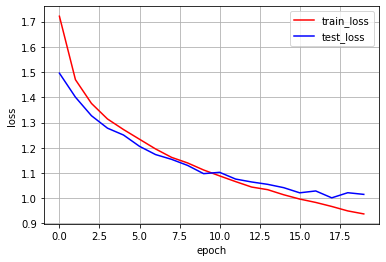

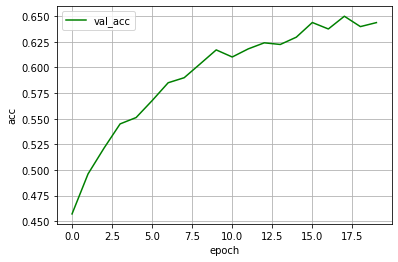

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure()
plt.plot(range(num_epochs), loss_list, 'r-', label='train_loss')
plt.plot(range(num_epochs), val_loss_list, 'b-', label='test_loss')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid()

plt.figure()
plt.plot(range(num_epochs), val_acc_list, 'g-', label='val_acc')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('acc')
plt.grid()

Files already downloaded and verified


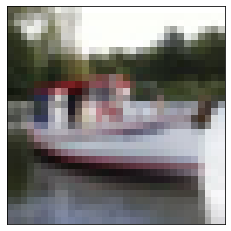

正解: ship 予測結果: ship


In [ ]:
cifar10 = torchvision.datasets.CIFAR10(root="mydata",
                       train=False,download=True,
                       transform=transforms.ToTensor())

dataiter = iter(torch.utils.data.DataLoader(cifar10, shuffle=True))
images, labels = next(dataiter)  # サンプルを1つだけ取り出す

plt.imshow(np.transpose(images[0], (1, 2, 0)))  # チャンネルを一番後ろに
plt.tick_params(labelbottom=False, labelleft=False, bottom=False, left=False)  # ラベルとメモリを非表示に
plt.show()


model.eval()  # 評価モード
imagee, labele = images.cuda(), labels.cuda()  # GPU対応
with torch.no_grad():
  labely = model(imagee)
print("正解:", classes[labels[0]],
      "予測結果:", classes[labely.argmax().item()])

# 課題2は省略